# Importing Modules and Data

In [1]:
from learntools import Network, Learning
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
#https://www.ajbell.co.uk/market-research/sub/FUND:BJS8SJ3/charts-performance

# Defining the Broker and Relevant Functions

In [2]:
class broker:
    def __init__(self,data,dates,tradingBot,interest_rate=0):
        self.cash = 0 
        self.indexSum = 1 # starts with all money in index
        self.dateIndex = 0 
        self.dates = dates
        self.data = data / data[-1] # index is normalised to 1.0 start
        self.maxDate = len(data)
        self.tradingBot = tradingBot
        self.interest_rate = interest_rate
        self.daily_interest_rate = interest_rate / 365

        self.totalValue = np.zeros(len(data))
        self.indexValue = np.zeros(len(data))
        self.cashValue = np.zeros(len(data))
        
        
        if len(data) != len(dates):
            print('Error: data length does not match date length')
            
    def buy(self,value: float):
        if value > self.cash:
            value = self.cash
            #print('Warning Buy Cash greater than amount held. DateIndex/Date=',self.dateIndex,self.dates[self.dateIndex])
        
        self.cash = self.cash - value
        self.indexSum = self.indexSum + value/self.data[self.dateIndex]
        
        
    def sell(self,value: float):
        if value > self.indexSum:
            value = self.indexSum
            #print('Warning Sell Value greater than amount held. DateIndex/Date=',self.dateIndex,self.dates[self.dateIndex])
        
        self.indexSum = self.indexSum - value
        self.cash = self.cash + value*self.data[self.dateIndex]
            
    def makeMove(self):
        # assuming we make the trade after close
        # we will have seen the close price.
        # we will be testing is the close price is over/under valued
        # we thus need to add +1 to the index due to python indexing. 
        # e.g day 1 (index=0) needs just todays price which is
        # data[:index+1] = int 
        seenData = self.data[:self.dateIndex+1] #if dateIndex is 0 it is first day
        seenDates = self.dates[:self.dateIndex+1]

        # function here input: seen data 
        # returns a number between 0 and 1
        # 1 being all portfolio in cash
        # 0 being all portfolio in stock
        action = self.tradingBot(seenData,seenDates) # add function here
        
        if action == -1: #pass
            pass
        else:
            currentValue = self.cash + self.indexSum * self.data[self.dateIndex] # current value of portfolio
            wantedValue = action * currentValue # wanted value in cash

            if self.cash > wantedValue: #if we have more cash than wanted
                #buy
                cashValue = self.cash-wantedValue
                self.buy(cashValue)

            elif self.cash < wantedValue: #if we have less cash than wanted
                #sell
                cashValue = wantedValue - self.cash
                indexValue = cashValue/self.data[self.dateIndex]
                self.sell(indexValue)

        self.indexValue[self.dateIndex] = self.indexSum
        self.cashValue[self.dateIndex] = self.cash #+ self.cash * self.daily_interest_rate # add interest
        self.totalValue[self.dateIndex] = self.cash + self.indexSum * self.data[self.dateIndex]
        self.dateIndex += 1 # after move is made, move to next date
        
    def run(self):
        while self.dateIndex < self.maxDate:
            self.makeMove()


            
    def plot(self,dataName: str):
        ax = plt.gca()
        plotDF = pd.DataFrame()
        plotDF['Dates'] = self.dates
        plotDF['Index'] = self.data
        plotDF['Trader'] = self.totalValue
        
        plotDF.plot(x='Dates',y='Trader',ax=ax)
        plotDF.plot(x='Dates',y='Index',ax=ax,label=dataName)
        plt.xticks(rotation=90)
        '''
        plt.plot(self.dates,self.data,label = dataName)
        plt.plot(self.dates,self.totalValue,label = 'Trader')
        
        plt.title(dataName+' vs Trader Performance')
        plt.legend()
        '''

    def lossFunc(net):
        pass

        
def testData(n):
    x = np.arange(1,n+1)
    y = np.sin(30*np.pi*x/n) + 5
    return x,y

def getData(ticker,df):
    DF = df.drop(df[df['Ticker']!=ticker].index)
    Data = np.asarray(DF['Open'],dtype=float)
    Dates = np.asarray(DF['Date'])
    return Data,Dates

def linearMemoryDiff(seenData,seenDates,memory=0):
    '''
    function to fit a linear regression to 
    memory number of datapoints back
    then take the difference of the 
    predicted vs actual value
    '''
    if memory == 0:
        return 0
    else:
        seenData = seenData[-memory:]
        seenDates = seenDates[-memory:]
    
    x = np.arange(0, len(seenData))
    y = seenData
    
    coeffs = np.polyfit(x, y, 1)
    fit = np.poly1d(coeffs)
    
    predictedValue = fit(x[-1])

    return seenData[-1]/predictedValue - 1



# Preprocessing Data

In [86]:
# creating Input Data from varing linear regression sizes
def preprocess(data,int_dates):

    memory_lengths = [10,20,30,40,50,75,100,150,200,len(data)] # most popular moving average 
    
    input_matrix = np.zeros((len(data),len(memory_lengths)))
    print(input_matrix.shape)
    
    for i in range(len(data)-1):
        i = i + 1
        seenData = data[:i]
        seenDates = int_dates[:i]
        for j in range(len(memory_lengths)):
            if i == 1:
                pass
            else:
                input_matrix[i][j] = linearMemoryDiff(seenData,seenDates,memory_lengths[j])

    return input_matrix


# Import Data

In [87]:
DF = pd.read_csv('SPX.MAX.csv')
DF['Date'] = pd.to_datetime(DF['Date'])
data = DF[(DF['Date'].dt.year < 2007) & (DF['Date'].dt.year > 2002)]['Close'].to_numpy()
int_dates = np.arange(0,len(data))

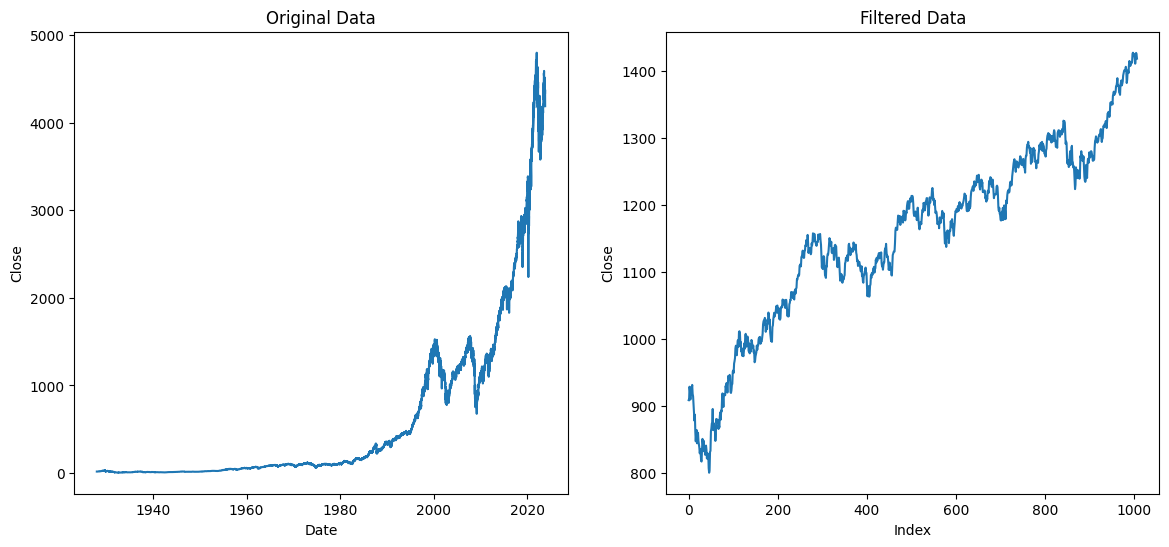

In [88]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the original data
ax1.plot(DF['Date'], DF['Close'])
ax1.set_title('Original Data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close')

# Plotting the filtered data
ax2.plot(data)
ax2.set_title('Filtered Data')
ax2.set_xlabel('Index')
ax2.set_ylabel('Close')

plt.show()


In [89]:
input_matrix = preprocess(data,int_dates)

def loss_func(net):
    bot = lambda seenData,seenDates: net.forward([input_matrix[len(seenData)-1]])[0][0]
    env = broker(data,int_dates,bot)
    env.dateIndex = 200
    env.run()
    return 1/env.totalValue[-1]

(1007, 10)


In [106]:
net1 = Network.network(10,1)
net1.add_layer(Network.layer_dense(10,10))
net1.add_layer(Network.relu())
net1.add_layer(Network.layer_dense(10,10))
net1.add_layer(Network.relu())
net1.add_layer(Network.layer_dense(10,10))
net1.add_layer(Network.relu())
net1.add_layer(Network.layer_dense(10,1))
net1.add_layer(Network.sigmoid())
net1.random_initilisation()

loss,_ = Learning.random_learning(net1,loss_func,info=True)

Iter 0 Loss 1.3574946872928195
Iter 1 Loss 1.356000610879127
Iter 2 Loss 1.341884118991854
Iter 3 Loss 1.340460772688072
Iter 4 Loss 1.3395236709408775
Iter 5 Loss 1.3369966509731475
Iter 6 Loss 1.3118675298182971
Iter 7 Loss 1.3012879444583745
Iter 8 Loss 1.295142610446232
Iter 9 Loss 1.2530473725542934
Iter 10 Loss 1.195840660365369
Iter 11 Loss 1.184922415702899
Iter 12 Loss 1.1685195052920399
Iter 13 Loss 1.1473551547261605
Iter 14 Loss 1.1241212325779115
Iter 15 Loss 1.089841556495489
Iter 16 Loss 1.0851938527713079
Iter 17 Loss 1.0537010661250183
Iter 18 Loss 1.040443999190339
Iter 19 Loss 1.0219613857069934
Iter 20 Loss 1.0188220903094078
Iter 21 Loss 1.0162202117995702
Iter 22 Loss 1.0119991363006942
Iter 23 Loss 1.008499048679191
Iter 24 Loss 1.0012657251977033
Iter 25 Loss 1.000934553027616
Iter 26 Loss 1.0004584928243616
Iter 27 Loss 1.0004464313734525
Iter 28 Loss 1.0003014903588998
Iter 29 Loss 1.000173480208337
Iter 30 Loss 1.0001190996706775
Iter 31 Loss 1.00010463603681

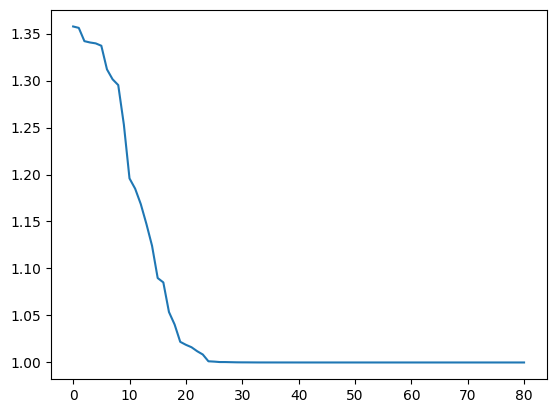

In [107]:
plt.plot(loss)

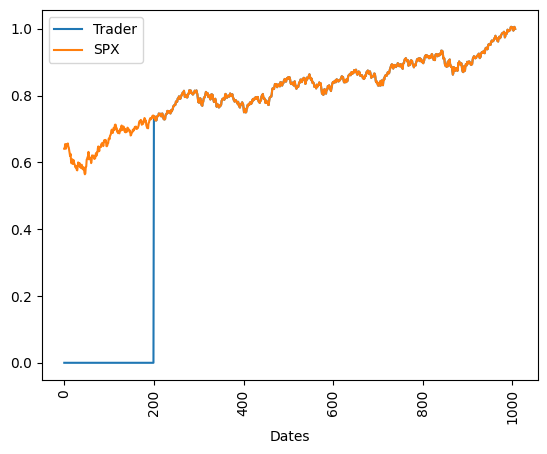

In [110]:
bot = lambda seenData,seenDates: net1.forward([input_matrix[len(seenData)-1]])[0][0]
env = broker(data,int_dates,bot)
env.dateIndex = 200
env.run()
env.plot('SPX')

In [111]:
loss,_ = Learning.random_learning(net1,loss_func,info=True)
plt.plot(loss)

Iter 0 Loss 0.9999999999999973


KeyboardInterrupt: 

In [112]:
from backtesting import Backtest, Strategy
from learntools import Learning, Network
#from backtesting import set_bokeh_output
#set_bokeh_output(notebook=False)

class SmaCross(Strategy):
    def init(self):
        self.inputs = preprocess(self.data.Close,np.arange(0,len(self.data.Close)))
        self.counter = 0
        self.buy()

    def next(self):
        
        
        if self.counter > 200:
            
            ind = net1.forward(self.inputs[self.counter-2:self.counter])
            #print(ind)
            if ind[1] > 0.5 and ind[0] < 0.5:
                self.sell()
            elif ind[1] < 0.5 and ind[0] > 0.5:
                self.buy()
            

        self.counter += 1

bt = Backtest(DF[-5000:], SmaCross,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()
print(output)
bt.plot()

C:\Users\wwden\AppData\Local\Temp\ipykernel_4956\4009220643.py:27: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(DF[-5000:], SmaCross,


(5000, 10)
Start                                 19070.0
End                                   24069.0
Duration                               4999.0
Exposure Time [%]                       99.98
Equity Final [$]                 38460.194226
Equity Peak [$]                  43537.455459
Return [%]                         282.894807
Buy & Hold Return [%]              292.004969
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -55.328329
Avg. Drawdown [%]                   -1.903504
Max. Drawdown Duration                 1376.0
Avg. Drawdown Duration                   21.0
# Trades                                  1.0
Win Rate [%]                            100.0
Best Trade [%]                     295.488167
Worst Trade [%]                    295.488167
Avg. Trade [%]         

C:\Users\wwden\OneDrive\Documents\GitHub\learntools-examples\venv\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\wwden\OneDrive\Documents\GitHub\learntools-examples\venv\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p6171', ...)

In [ ]:
print(net1)